In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For astronomical data (may use later in processing)
from astropy.table import Table
import lightkurve as lk

# Configure visualization
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
import pandas as pd

# Load dataset properly
df = pd.read_csv(
    "keplar_dataset.csv",
    sep=",",             # Correct separator
    comment="#",         # Skip metadata lines
    skipinitialspace=True
)

# Strip whitespace from headers
df.columns = df.columns.str.strip()

# ---- Dataset Summary ----
print("✅ Dataset successfully loaded and parsed!\n")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:15], "...")  # show first 15 cols only

print("\nFirst 5 rows of dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values per Column:")
print(df.isnull().sum().head(15))  # show first 15 cols

✅ Dataset successfully loaded and parsed!

Shape: (9564, 141)
Columns: ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment'] ...

First 5 rows of dataset:
   rowid     kepid kepoi_name   kepler_name koi_disposition koi_vet_stat  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED         Done   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED         Done   
2      3  10811496  K00753.01           NaN       CANDIDATE         Done   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE         Done   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED         Done   

  koi_vet_date koi_pdisposition  koi_score  koi_fpflag_nt  ...  \
0   2018-08-16        CANDIDATE      1.000              0  ...   
1   2018-08-16        CANDIDATE      0.969              0  ...   
2   2018-08-

In [3]:
# Unique dispositions
print("Planet dispositions:", df['koi_disposition'].value_counts(), "\n")

# How many confirmed planets
print("Number of confirmed exoplanets:", (df['koi_disposition'] == "CONFIRMED").sum())

# Average radius of confirmed planets
print("Average radius (Earth radii):", df.loc[df['koi_disposition']=="CONFIRMED", 'koi_prad'].mean())

# Small habitable-zone candidates (example filter)
habitable_candidates = df[
    (df['koi_disposition']=="CANDIDATE") &
    (df['koi_prad'] < 2.0) &                   # smaller than 2 Earth radii
    (df['koi_insol'].between(0.5, 2.0))        # roughly Earth-like flux
]
print("Potential habitable candidates:", habitable_candidates.shape[0])


Planet dispositions: koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64 

Number of confirmed exoplanets: 2746
Average radius (Earth radii): 2.8573724489795915
Potential habitable candidates: 61


# 3. Metadata & Inventory

Let's examine the dataset structure in detail and identify our target variable and key features for exoplanet classification.

In [4]:
# ---- METADATA & INVENTORY ----
print("=== KEPLER DATASET INVENTORY ===\n")

# Dataset dimensions
print(f"📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📊 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

# Target variable analysis - Key for classification
print("🎯 TARGET VARIABLE: koi_disposition (Exoplanet Archive Disposition)")
target_counts = df['koi_disposition'].value_counts()
print(target_counts)
print(f"Target distribution: {(target_counts / len(df) * 100).round(2).to_dict()}")

# Alternative target: koi_pdisposition (Disposition Using Kepler Data)
print("\n🎯 ALTERNATIVE TARGET: koi_pdisposition (Kepler-only classification)")
alt_target_counts = df['koi_pdisposition'].value_counts()
print(alt_target_counts)

print("\n" + "="*50)

# Key feature categories for exoplanet detection
feature_categories = {
    "🪐 Planetary Parameters": [
        'koi_period', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol'
    ],
    "🌟 Stellar Parameters": [
        'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_smet'
    ],
    "🔭 Transit Parameters": [
        'koi_duration', 'koi_depth', 'koi_ror', 'koi_impact', 'koi_model_snr'
    ],
    "📊 Statistical/Quality": [
        'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'
    ]
}

for category, features in feature_categories.items():
    print(f"\n{category}:")
    available_features = [f for f in features if f in df.columns]
    print(f"  Available: {len(available_features)}/{len(features)}")
    for feature in available_features[:3]:  # Show first 3
        missing_pct = (df[feature].isnull().sum() / len(df)) * 100
        print(f"    {feature}: {missing_pct:.1f}% missing")
    if len(available_features) > 3:
        print(f"    ... and {len(available_features)-3} more")

print(f"\n📈 Total numeric columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"📝 Total categorical columns: {df.select_dtypes(include=['object']).shape[1]}")

# Save inventory
inventory = {
    'dataset_name': 'Kepler KOI Dataset',
    'shape': df.shape,
    'target_variable': 'koi_disposition',
    'class_distribution': target_counts.to_dict(),
    'total_features': df.shape[1],
    'numeric_features': df.select_dtypes(include=[np.number]).shape[1],
    'categorical_features': df.select_dtypes(include=['object']).shape[1]
}

print(f"\n✅ Dataset inventory completed!")

=== KEPLER DATASET INVENTORY ===

📊 Dataset Shape: 9564 rows × 141 columns
📊 Memory Usage: 19.73 MB

🎯 TARGET VARIABLE: koi_disposition (Exoplanet Archive Disposition)
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
Target distribution: {'FALSE POSITIVE': 50.6, 'CONFIRMED': 28.71, 'CANDIDATE': 20.69}

🎯 ALTERNATIVE TARGET: koi_pdisposition (Kepler-only classification)
koi_pdisposition
FALSE POSITIVE    4847
CANDIDATE         4717
Name: count, dtype: int64


🪐 Planetary Parameters:
  Available: 6/6
    koi_period: 0.0% missing
    koi_prad: 3.8% missing
    koi_sma: 3.8% missing
    ... and 3 more

🌟 Stellar Parameters:
  Available: 5/5
    koi_steff: 3.8% missing
    koi_slogg: 3.8% missing
    koi_srad: 3.8% missing
    ... and 2 more

🔭 Transit Parameters:
  Available: 5/5
    koi_duration: 0.0% missing
    koi_depth: 3.8% missing
    koi_ror: 3.8% missing
    ... and 2 more

📊 Statistical/Quality:
  Available: 5/5
    ko

# 4. Data Cleaning & Preprocessing

Clean the dataset by handling missing values, standardizing categorical variables, and preparing for analysis.

In [5]:
# ---- DATA CLEANING ----
print("=== DATA CLEANING PHASE ===\n")

# Create a copy for cleaning
df_clean = df.copy()
initial_shape = df_clean.shape

print(f"🔄 Starting with: {initial_shape[0]} rows × {initial_shape[1]} columns\n")

# 1. Standardize target variable (most important for ML)
print("1️⃣ Standardizing target variable...")
print("Original koi_disposition values:", df_clean['koi_disposition'].unique())

# Create clean binary classification target
target_mapping = {
    'CONFIRMED': 'CONFIRMED',
    'CANDIDATE': 'CANDIDATE', 
    'FALSE POSITIVE': 'FALSE_POSITIVE'
}

df_clean['disposition_clean'] = df_clean['koi_disposition'].map(target_mapping)
print("✅ Created 'disposition_clean' column")
print("New target distribution:", df_clean['disposition_clean'].value_counts())

# 2. Handle critical missing values
print(f"\n2️⃣ Handling missing values...")

# Key features for exoplanet detection
critical_features = [
    'koi_period', 'koi_prad', 'koi_duration', 'koi_depth', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass'
]

missing_before = df_clean[critical_features].isnull().sum()
print("Missing values in critical features BEFORE cleaning:")
print(missing_before[missing_before > 0])

# Strategy: Drop rows with missing target or too many missing critical features
initial_count = len(df_clean)

# Drop rows with missing target
df_clean = df_clean.dropna(subset=['disposition_clean'])
after_target_drop = len(df_clean)

# Drop rows missing more than 50% of critical features
critical_missing_count = df_clean[critical_features].isnull().sum(axis=1)
df_clean = df_clean[critical_missing_count < len(critical_features) * 0.5]
after_critical_drop = len(df_clean)

print(f"✅ Dropped {initial_count - after_target_drop} rows with missing target")
print(f"✅ Dropped {after_target_drop - after_critical_drop} rows with >50% missing critical features")

# 3. Fill remaining missing values strategically
print(f"\n3️⃣ Imputing remaining missing values...")

# For numerical features, use median imputation
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_features:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

# For categorical features, use mode or 'Unknown'
categorical_features = df_clean.select_dtypes(include=['object']).columns
for col in categorical_features:
    if df_clean[col].isnull().sum() > 0:
        if col in ['koi_comment']:
            df_clean[col].fillna('NO_COMMENT', inplace=True)
        else:
            mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
            df_clean[col].fillna(mode_val, inplace=True)

final_shape = df_clean.shape
print(f"✅ Cleaning completed!")
print(f"📊 Final dataset: {final_shape[0]} rows × {final_shape[1]} columns")
print(f"📉 Removed {initial_shape[0] - final_shape[0]} rows ({((initial_shape[0] - final_shape[0])/initial_shape[0]*100):.1f}%)")

# Verify no missing values in critical features
remaining_missing = df_clean[critical_features].isnull().sum().sum()
print(f"🎯 Missing values in critical features AFTER cleaning: {remaining_missing}")

print("\n" + "="*50)

=== DATA CLEANING PHASE ===

🔄 Starting with: 9564 rows × 141 columns

1️⃣ Standardizing target variable...
Original koi_disposition values: ['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE']
✅ Created 'disposition_clean' column
New target distribution: disposition_clean
FALSE_POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

2️⃣ Handling missing values...
Missing values in critical features BEFORE cleaning:
koi_prad         363
koi_depth        363
koi_model_snr    363
koi_steff        363
koi_slogg        363
koi_srad         363
koi_smass        363
dtype: int64
✅ Dropped 0 rows with missing target
✅ Dropped 363 rows with >50% missing critical features

3️⃣ Imputing remaining missing values...


C:\Users\hadee\AppData\Local\Temp\ipykernel_15096\3875543347.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
C:\Users\hadee\AppData\Local\Temp\ipykernel_15096\3875543347.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

✅ Cleaning completed!
📊 Final dataset: 9201 rows × 142 columns
📉 Removed 363 rows (3.8%)
🎯 Missing values in critical features AFTER cleaning: 0



# 5. Exploratory Data Analysis (EDA)

Comprehensive analysis to understand distributions, relationships, and patterns in the exoplanet data.

=== EXPLORATORY DATA ANALYSIS ===

1️⃣ Class Balance Analysis


C:\Users\hadee\AppData\Local\Temp\ipykernel_15096\2329250738.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='disposition_clean', palette=colors, ax=axes[1])


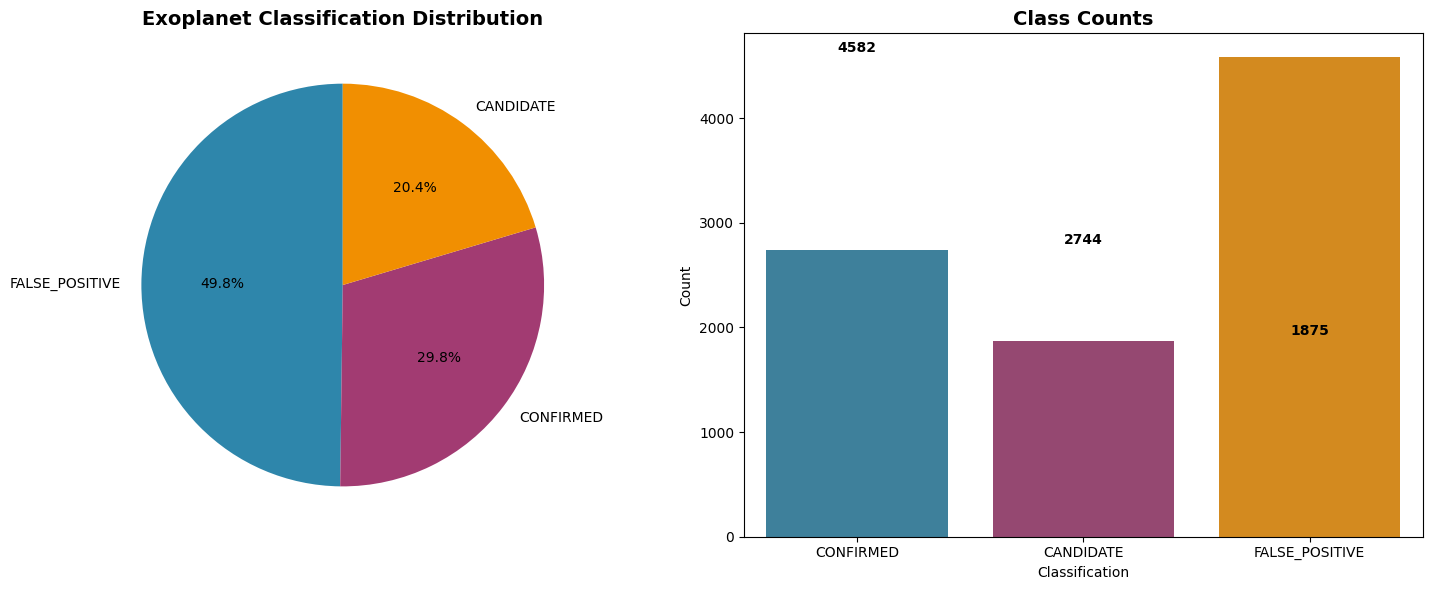

📊 Class Distribution:
  FALSE_POSITIVE: 4582 samples (49.8%)
  CONFIRMED: 2744 samples (29.8%)
  CANDIDATE: 1875 samples (20.4%)
⚖️  Class balance ratio: 0.409
✅ Classes are reasonably balanced.


In [6]:
# ---- EXPLORATORY DATA ANALYSIS ----
print("=== EXPLORATORY DATA ANALYSIS ===\n")

# Set up the plotting environment
plt.style.use('default')
fig_size = (15, 10)

# 1. CLASS BALANCE ANALYSIS
print("1️⃣ Class Balance Analysis")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
class_counts = df_clean['disposition_clean'].value_counts()
colors = ['#2E86AB', '#A23B72', '#F18F01']
axes[0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Exoplanet Classification Distribution', fontsize=14, fontweight='bold')

# Bar plot with counts
sns.countplot(data=df_clean, x='disposition_clean', palette=colors, ax=axes[1])
axes[1].set_title('Class Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classification')
axes[1].set_ylabel('Count')

# Add count labels on bars
for i, v in enumerate(class_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print class statistics
print("📊 Class Distribution:")
for cls, count in class_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"  {cls}: {count} samples ({pct:.1f}%)")

# Check for class imbalance
min_class_ratio = class_counts.min() / class_counts.max()
print(f"⚖️  Class balance ratio: {min_class_ratio:.3f}")
if min_class_ratio < 0.3:
    print("⚠️  WARNING: Significant class imbalance detected! Consider resampling techniques.")
else:
    print("✅ Classes are reasonably balanced.")


2️⃣ Distribution Analysis of Key Features


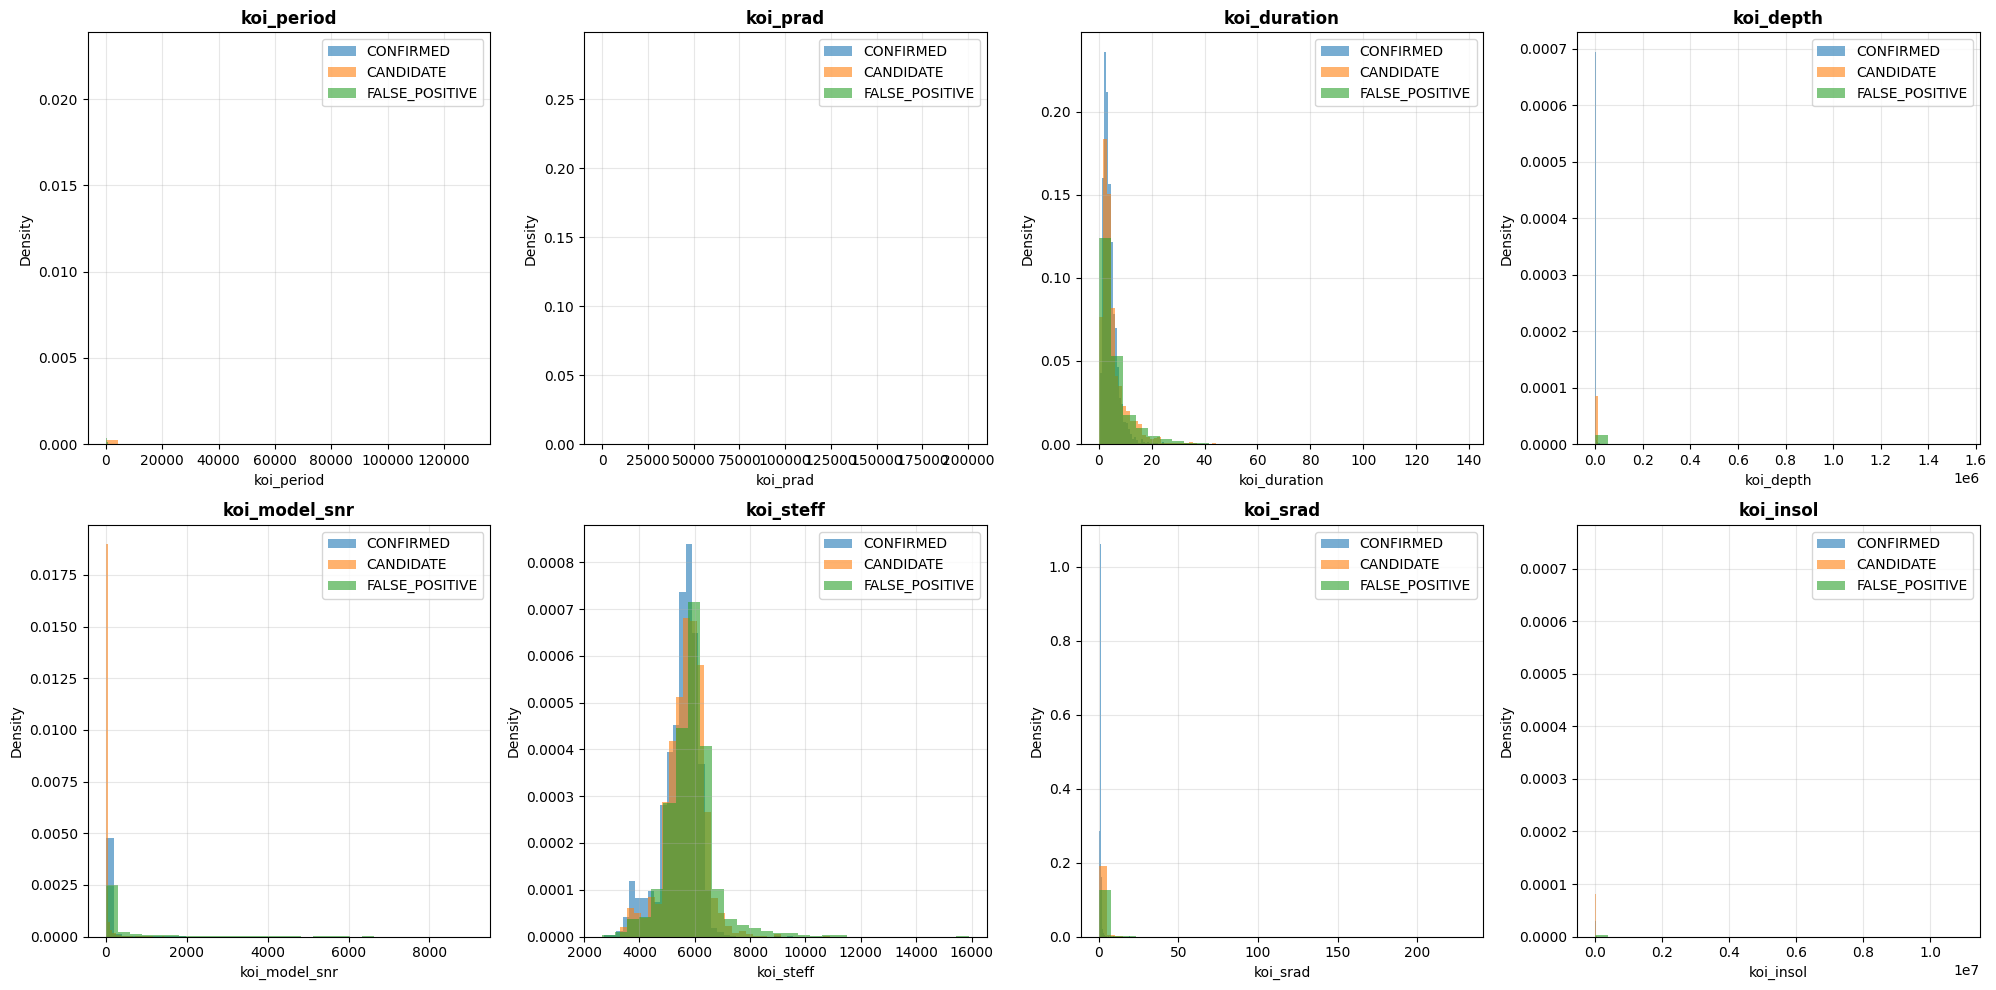

📈 Statistical Summary of Key Features:
       koi_period    koi_prad  koi_duration    koi_depth  koi_model_snr  \
count    9201.000    9201.000      9201.000     9201.000       9201.000   
mean       74.308     102.892         5.655    23791.336        259.895   
std      1360.539    3077.639         6.500    82242.683        795.807   
min         0.242       0.080         0.052        0.000          0.000   
25%         2.683       1.400         2.454      159.900         12.000   
50%         9.297       2.390         3.824      421.100         23.000   
75%        36.857      14.930         6.289     1473.400         78.000   
max    129995.778  200346.000       138.540  1541400.000       9054.700   

       koi_steff  koi_srad     koi_insol  
count   9201.000  9201.000  9.201000e+03  
mean    5706.823     1.729  7.716611e+03  
std      796.858     6.127  1.595455e+05  
min     2661.000     0.109  0.000000e+00  
25%     5310.000     0.829  2.001000e+01  
50%     5767.000     1.000 

In [7]:
# 2. DISTRIBUTIONS OF KEY VARIABLES
print(f"\n2️⃣ Distribution Analysis of Key Features")

# Key features for exoplanet detection
key_features = [
    'koi_period', 'koi_prad', 'koi_duration', 'koi_depth', 
    'koi_model_snr', 'koi_steff', 'koi_srad', 'koi_insol'
]

# Filter available features
available_key_features = [f for f in key_features if f in df_clean.columns and df_clean[f].notna().sum() > 100]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(available_key_features[:8]):
    # Create subplot
    ax = axes[i]
    
    # Plot distributions by class
    for cls in df_clean['disposition_clean'].unique():
        data = df_clean[df_clean['disposition_clean'] == cls][feature].dropna()
        if len(data) > 0:
            ax.hist(data, alpha=0.6, label=cls, bins=30, density=True)
    
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for j in range(len(available_key_features), 8):
    axes[j].remove()

plt.tight_layout()
plt.show()

# Statistical summary
print("📈 Statistical Summary of Key Features:")
summary_stats = df_clean[available_key_features].describe()
print(summary_stats.round(3))


3️⃣ Correlation Analysis


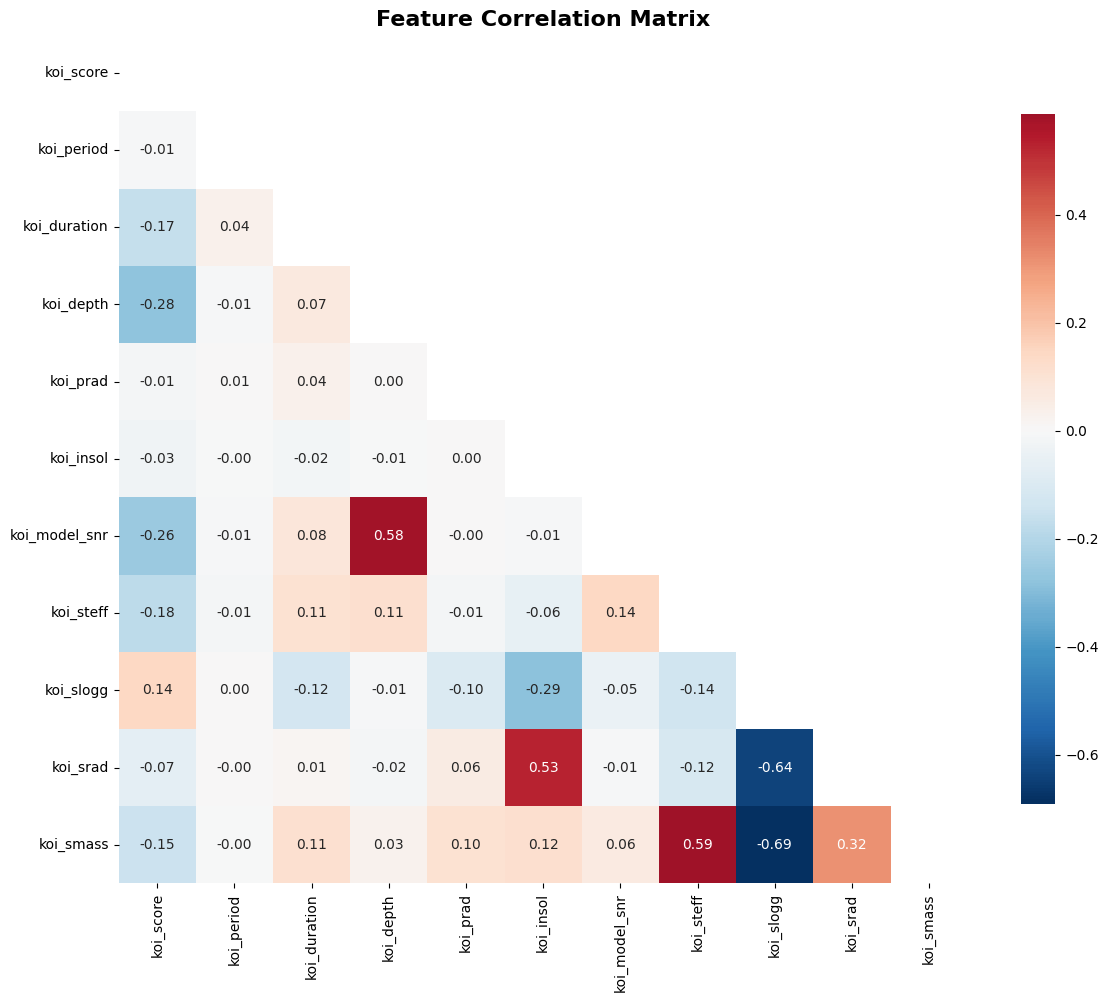

🔗 Highly Correlated Feature Pairs (|r| > 0.7):
  ✅ No highly correlated features found.


In [8]:
# 3. CORRELATION ANALYSIS
print(f"\n3️⃣ Correlation Analysis")

# Select numeric features for correlation
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
correlation_features = [f for f in numeric_features if f in available_key_features + ['koi_score', 'koi_smass', 'koi_slogg']]

# Calculate correlation matrix
corr_matrix = df_clean[correlation_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("🔗 Highly Correlated Feature Pairs (|r| > 0.7):")
for feat1, feat2, corr_val in high_corr_pairs:
    print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")

if not high_corr_pairs:
    print("  ✅ No highly correlated features found.")


4️⃣ Outlier Detection


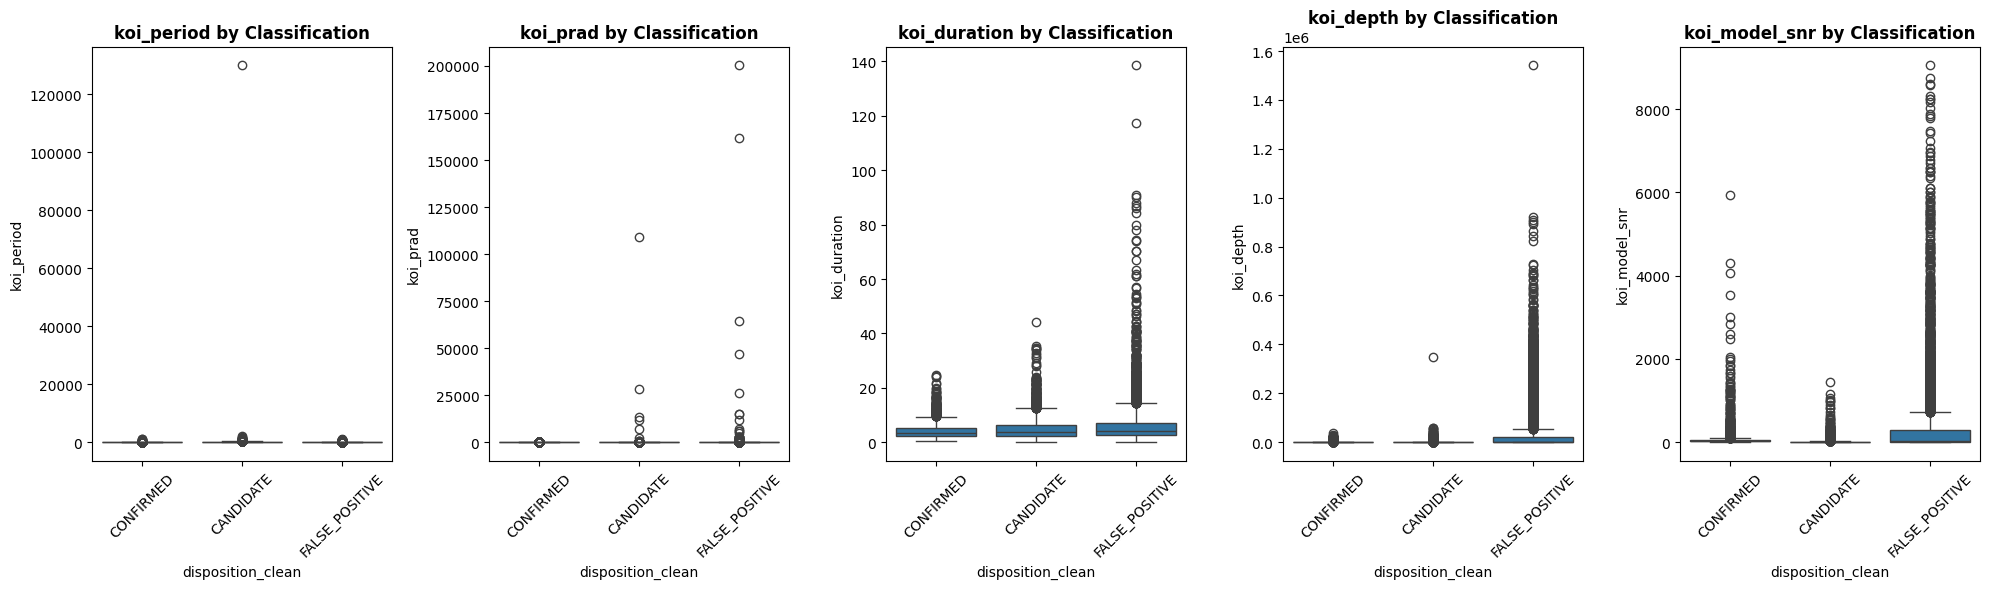

📊 Outlier Analysis (IQR method):
  koi_period: 1507 outliers (16.4%)
  koi_prad: 1469 outliers (16.0%)
  koi_duration: 841 outliers (9.1%)
  koi_depth: 1798 outliers (19.5%)
  koi_model_snr: 1600 outliers (17.4%)

📏 Feature Ranges:
  koi_period: 0.242 to 129995.778
  koi_prad: 0.080 to 200346.000
  koi_duration: 0.052 to 138.540
  koi_depth: 0.000 to 1541400.000
  koi_model_snr: 0.000 to 9054.700


In [9]:
# 4. OUTLIER DETECTION
print(f"\n4️⃣ Outlier Detection")

# Key features for outlier analysis
outlier_features = ['koi_period', 'koi_prad', 'koi_duration', 'koi_depth', 'koi_model_snr']
available_outlier_features = [f for f in outlier_features if f in df_clean.columns]

# Box plots for outlier visualization
fig, axes = plt.subplots(1, len(available_outlier_features), figsize=(20, 6))
if len(available_outlier_features) == 1:
    axes = [axes]

for i, feature in enumerate(available_outlier_features):
    sns.boxplot(data=df_clean, y=feature, x='disposition_clean', ax=axes[i])
    axes[i].set_title(f'{feature} by Classification', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical outlier detection using IQR method
print("📊 Outlier Analysis (IQR method):")
outlier_summary = {}

for feature in available_outlier_features:
    data = df_clean[feature].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct = (len(outliers) / len(data)) * 100
    
    outlier_summary[feature] = {
        'count': len(outliers),
        'percentage': outlier_pct,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    print(f"  {feature}: {len(outliers)} outliers ({outlier_pct:.1f}%)")

# Feature ranges for context
print(f"\n📏 Feature Ranges:")
for feature in available_outlier_features:
    min_val = df_clean[feature].min()
    max_val = df_clean[feature].max()
    print(f"  {feature}: {min_val:.3f} to {max_val:.3f}")

# 6. Feature Engineering

Create new features and prepare data for machine learning algorithms.

In [10]:
# ---- FEATURE ENGINEERING ----
print("=== FEATURE ENGINEERING ===\n")

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle

# Create feature engineering copy
df_features = df_clean.copy()

print("1️⃣ Creating Derived Features...")

# 1. Logarithmic transformations for skewed features
log_features = ['koi_period', 'koi_prad', 'koi_duration']
for feature in log_features:
    if feature in df_features.columns:
        # Add small constant to handle zero values
        df_features[f'{feature}_log'] = np.log1p(df_features[feature])
        print(f"✅ Created {feature}_log")

# 2. Ratio and interaction features
if 'koi_depth' in df_features.columns and 'koi_duration' in df_features.columns:
    df_features['depth_duration_ratio'] = df_features['koi_depth'] / (df_features['koi_duration'] + 1e-6)
    print("✅ Created depth_duration_ratio")

if 'koi_prad' in df_features.columns and 'koi_srad' in df_features.columns:
    df_features['planet_star_radius_ratio'] = df_features['koi_prad'] / (df_features['koi_srad'] + 1e-6)
    print("✅ Created planet_star_radius_ratio")

if 'koi_insol' in df_features.columns:
    df_features['insol_log'] = np.log1p(df_features['koi_insol'])
    df_features['habitable_zone'] = ((df_features['koi_insol'] >= 0.5) & (df_features['koi_insol'] <= 2.0)).astype(int)
    print("✅ Created insol_log and habitable_zone flag")

# 3. Stellar quality indicators
if 'koi_steff' in df_features.columns:
    df_features['stellar_temp_category'] = pd.cut(df_features['koi_steff'], 
                                                 bins=[0, 4000, 5500, 7000, 50000], 
                                                 labels=['Cool', 'Warm', 'Hot', 'Very_Hot'])
    print("✅ Created stellar_temp_category")

# 4. False positive flag combination
fp_flags = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
available_fp_flags = [f for f in fp_flags if f in df_features.columns]
if len(available_fp_flags) > 0:
    df_features['total_fp_flags'] = df_features[available_fp_flags].sum(axis=1)
    print("✅ Created total_fp_flags")

print(f"\n📊 Features after engineering: {df_features.shape[1]} columns")

print(f"\n2️⃣ Preparing Features for ML...")

# Select features for ML
# Numeric features
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and target-related columns
exclude_cols = ['rowid', 'kepid', 'disposition_clean', 'koi_disposition', 'koi_pdisposition', 
                'koi_kepmag', 'ra', 'dec']  # Keep coordinates separate for now
ml_numeric_features = [f for f in numeric_features if f not in exclude_cols]

# Key categorical features to encode
categorical_features_to_encode = ['stellar_temp_category']
available_categorical = [f for f in categorical_features_to_encode if f in df_features.columns]

print(f"📈 Selected {len(ml_numeric_features)} numeric features for ML")
print(f"📝 Selected {len(available_categorical)} categorical features for encoding")

# Handle any remaining infinite or very large values
df_features[ml_numeric_features] = df_features[ml_numeric_features].replace([np.inf, -np.inf], np.nan)

# Final imputation for any new NaN values created during feature engineering
for col in ml_numeric_features:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)

print("✅ Cleaned infinite values and remaining NaNs")

=== FEATURE ENGINEERING ===

1️⃣ Creating Derived Features...
✅ Created koi_period_log
✅ Created koi_prad_log
✅ Created koi_duration_log
✅ Created depth_duration_ratio
✅ Created planet_star_radius_ratio
✅ Created insol_log and habitable_zone flag
✅ Created stellar_temp_category
✅ Created total_fp_flags

📊 Features after engineering: 151 columns

2️⃣ Preparing Features for ML...
📈 Selected 127 numeric features for ML
📝 Selected 1 categorical features for encoding
✅ Cleaned infinite values and remaining NaNs


c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\hadee\AppData\Local\Temp\ipykernel_15096\47797806.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features[col].fillna(median_val, inplace=True)
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean

In [11]:
# 3️⃣ Feature Scaling and Encoding
print(f"\n3️⃣ Feature Scaling and Encoding...")

# Prepare feature matrix X and target vector y
X = df_features[ml_numeric_features].copy()
y = df_features['disposition_clean'].copy()

print(f"📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")

# Encode categorical target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("✅ Target encoding:")
for i, class_name in enumerate(le_target.classes_):
    count = (y_encoded == i).sum()
    print(f"  {class_name}: {i} ({count} samples)")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("✅ Applied StandardScaler to features")

# Alternative scaling for tree-based models
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)
X_minmax_df = pd.DataFrame(X_minmax, columns=X.columns, index=X.index)

print("✅ Applied MinMaxScaler (alternative for tree models)")

print(f"\n4️⃣ Data Splitting...")

# Stratified split to maintain class distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_df, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("📊 Data split summary:")
print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Testing: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\n📈 Class distribution verification:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    class_dist = np.bincount(y_split) / len(y_split)
    print(f"  {split_name}: {[f'{d:.3f}' for d in class_dist]}")

print("\n" + "="*50)


3️⃣ Feature Scaling and Encoding...
📊 Feature matrix shape: (9201, 127)
🎯 Target vector shape: (9201,)
✅ Target encoding:
  CANDIDATE: 0 (1875 samples)
  CONFIRMED: 1 (2744 samples)
  FALSE_POSITIVE: 2 (4582 samples)
✅ Applied StandardScaler to features
✅ Applied MinMaxScaler (alternative for tree models)

4️⃣ Data Splitting...
📊 Data split summary:
  Training: 5520 samples (60.0%)
  Validation: 1840 samples (20.0%)
  Testing: 1841 samples (20.0%)

📈 Class distribution verification:
  Train: ['0.204', '0.298', '0.498']
  Val: ['0.204', '0.298', '0.498']
  Test: ['0.204', '0.298', '0.498']



c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanm

# 7. Save Processed Dataset

Save the cleaned and processed data along with transformers for the ML phase.

In [12]:
# ---- SAVE PROCESSED DATASETS ----
print("=== SAVING PROCESSED DATASETS ===\n")

import os

# Create directories
os.makedirs('data/processed', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)

print("1️⃣ Saving train/validation/test splits...")

# Save split datasets (StandardScaler version)
datasets = {
    'train': (X_train, y_train),
    'val': (X_val, y_val), 
    'test': (X_test, y_test)
}

for split_name, (X_split, y_split) in datasets.items():
    # Combine features and target
    split_df = X_split.copy()
    split_df['target'] = y_split
    split_df['target_name'] = le_target.inverse_transform(y_split)
    
    # Save to CSV
    split_df.to_csv(f'data/processed/kepler_{split_name}.csv', index=False)
    print(f"✅ Saved data/processed/kepler_{split_name}.csv ({split_df.shape[0]} rows)")

# Save MinMax scaled version for tree-based models
X_train_mm, X_temp_mm, y_train_mm, y_temp_mm = train_test_split(
    X_minmax_df, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)
X_val_mm, X_test_mm, y_val_mm, y_test_mm = train_test_split(
    X_temp_mm, y_temp_mm, test_size=0.5, random_state=42, stratify=y_temp_mm
)

datasets_mm = {
    'train_minmax': (X_train_mm, y_train_mm),
    'val_minmax': (X_val_mm, y_val_mm),
    'test_minmax': (X_test_mm, y_test_mm)
}

for split_name, (X_split, y_split) in datasets_mm.items():
    split_df = X_split.copy()
    split_df['target'] = y_split
    split_df['target_name'] = le_target.inverse_transform(y_split)
    split_df.to_csv(f'data/processed/kepler_{split_name}.csv', index=False)
    print(f"✅ Saved data/processed/kepler_{split_name}.csv")

print(f"\n2️⃣ Saving transformers and metadata...")

# Save transformers
transformers = {
    'standard_scaler': scaler,
    'minmax_scaler': minmax_scaler,
    'label_encoder': le_target
}

for name, transformer in transformers.items():
    with open(f'artifacts/{name}.pkl', 'wb') as f:
        pickle.dump(transformer, f)
    print(f"✅ Saved artifacts/{name}.pkl")

# Save feature metadata
feature_metadata = {
    'feature_names': ml_numeric_features,
    'n_features': len(ml_numeric_features),
    'target_classes': le_target.classes_.tolist(),
    'n_classes': len(le_target.classes_),
    'dataset_shape': df_features.shape,
    'split_sizes': {
        'train': len(X_train),
        'val': len(X_val),
        'test': len(X_test)
    }
}

with open('artifacts/feature_metadata.pkl', 'wb') as f:
    pickle.dump(feature_metadata, f)
print("✅ Saved artifacts/feature_metadata.pkl")

print(f"\n3️⃣ Saving full processed dataset...")
# Save the complete processed dataset
df_features.to_csv('data/processed/kepler_full_processed.csv', index=False)
print(f"✅ Saved data/processed/kepler_full_processed.csv ({df_features.shape[0]} rows × {df_features.shape[1]} cols)")

print(f"\n✅ All datasets and artifacts saved successfully!")
print(f"📁 Files created:")
print(f"  📊 data/processed/kepler_train.csv")
print(f"  📊 data/processed/kepler_val.csv") 
print(f"  📊 data/processed/kepler_test.csv")
print(f"  📊 data/processed/kepler_train_minmax.csv")
print(f"  📊 data/processed/kepler_val_minmax.csv")
print(f"  📊 data/processed/kepler_test_minmax.csv")
print(f"  📊 data/processed/kepler_full_processed.csv")
print(f"  🔧 artifacts/standard_scaler.pkl")
print(f"  🔧 artifacts/minmax_scaler.pkl")
print(f"  🔧 artifacts/label_encoder.pkl")
print(f"  🔧 artifacts/feature_metadata.pkl")

=== SAVING PROCESSED DATASETS ===

1️⃣ Saving train/validation/test splits...
✅ Saved data/processed/kepler_train.csv (5520 rows)
✅ Saved data/processed/kepler_val.csv (1840 rows)
✅ Saved data/processed/kepler_test.csv (1841 rows)
✅ Saved data/processed/kepler_train_minmax.csv
✅ Saved data/processed/kepler_val_minmax.csv
✅ Saved data/processed/kepler_test_minmax.csv

2️⃣ Saving transformers and metadata...
✅ Saved artifacts/standard_scaler.pkl
✅ Saved artifacts/minmax_scaler.pkl
✅ Saved artifacts/label_encoder.pkl
✅ Saved artifacts/feature_metadata.pkl

3️⃣ Saving full processed dataset...
✅ Saved data/processed/kepler_full_processed.csv (9201 rows × 151 cols)

✅ All datasets and artifacts saved successfully!
📁 Files created:
  📊 data/processed/kepler_train.csv
  📊 data/processed/kepler_val.csv
  📊 data/processed/kepler_test.csv
  📊 data/processed/kepler_train_minmax.csv
  📊 data/processed/kepler_val_minmax.csv
  📊 data/processed/kepler_test_minmax.csv
  📊 data/processed/kepler_full_pr

# 8. Dataset Documentation & ML Readiness Summary

Final summary and documentation for the Machine Learning team.

In [13]:
# ---- DATASET DOCUMENTATION & ML READINESS ----
print("=== KEPLER EXOPLANET DATASET - ML READINESS REPORT ===")
print("🚀 NASA Space Apps Challenge - Exoplanet Detection Project\n")

print("="*60)
print("📋 DATASET SUMMARY")
print("="*60)
print(f"📊 Original Dataset: {initial_shape[0]} rows × {initial_shape[1]} columns")
print(f"📊 Processed Dataset: {df_features.shape[0]} rows × {df_features.shape[1]} columns")
print(f"📉 Data Reduction: {((initial_shape[0] - df_features.shape[0])/initial_shape[0]*100):.1f}% rows removed")
print(f"🎯 Target Variable: disposition_clean (3 classes)")
print(f"🔢 Features for ML: {len(ml_numeric_features)} numeric features")

print(f"\n📈 Class Distribution:")
final_class_counts = df_features['disposition_clean'].value_counts()
for cls, count in final_class_counts.items():
    pct = (count / len(df_features)) * 100
    print(f"  • {cls}: {count:,} samples ({pct:.1f}%)")

print(f"\n" + "="*60)
print("🔧 FEATURE ENGINEERING SUMMARY")
print("="*60)
print("✅ Applied transformations:")
print("  • Log transformations: koi_period, koi_prad, koi_duration")
print("  • Ratio features: depth_duration_ratio, planet_star_radius_ratio") 
print("  • Derived features: habitable_zone flag, stellar_temp_category")
print("  • Combined flags: total_fp_flags")
print("  • Scaling: StandardScaler (default) + MinMaxScaler (trees)")

print(f"\n📊 Key Features for Exoplanet Detection:")
top_features = ['koi_period', 'koi_prad', 'koi_duration', 'koi_depth', 'koi_model_snr', 
                'koi_steff', 'koi_score', 'depth_duration_ratio']
available_top = [f for f in top_features if f in ml_numeric_features]
for i, feature in enumerate(available_top[:8], 1):
    print(f"  {i}. {feature}")

print(f"\n" + "="*60)
print("💾 OUTPUT FILES FOR ML TEAM")
print("="*60)
print("📁 Ready-to-use datasets:")
print("  🟢 data/processed/kepler_train.csv")
print("  🟡 data/processed/kepler_val.csv")
print("  🔴 data/processed/kepler_test.csv")
print("  🌳 data/processed/kepler_*_minmax.csv (for tree models)")

print(f"\n🔧 Preprocessing artifacts:")
print("  📦 artifacts/standard_scaler.pkl")
print("  📦 artifacts/minmax_scaler.pkl")
print("  📦 artifacts/label_encoder.pkl")
print("  📦 artifacts/feature_metadata.pkl")

print(f"\n" + "="*60)
print("🎯 ML RECOMMENDATIONS")
print("="*60)
print("🤖 Suggested ML approaches:")
print("  1. Random Forest/XGBoost (use MinMax scaled data)")
print("  2. SVM/Logistic Regression (use Standard scaled data)")
print("  3. Neural Networks (use Standard scaled data)")
print("  4. Ensemble methods combining multiple approaches")

print(f"\n⚖️  Class Imbalance Strategy:")
min_class_ratio = final_class_counts.min() / final_class_counts.max()
if min_class_ratio < 0.3:
    print("  ⚠️  Consider: SMOTE, class weights, or stratified sampling")
else:
    print("  ✅ Classes reasonably balanced - proceed with standard training")

print(f"\n🎨 Evaluation Metrics:")
print("  • Primary: F1-score (macro/weighted)")
print("  • Secondary: Precision, Recall, ROC-AUC")
print("  • Classification Report with confusion matrix")

print(f"\n🔍 Next Steps for ML Team:")
print("  1. Load processed datasets from data/processed/")
print("  2. Load transformers from artifacts/ for new data")
print("  3. Implement cross-validation strategy")
print("  4. Try multiple algorithms and compare performance")
print("  5. Tune hyperparameters for best models")
print("  6. Generate final predictions on test set")

print(f"\n" + "="*60)
print("✅ DATASET PROCESSING COMPLETE!")
print("🚀 Ready for Machine Learning Phase!")
print("="*60)

=== KEPLER EXOPLANET DATASET - ML READINESS REPORT ===
🚀 NASA Space Apps Challenge - Exoplanet Detection Project

📋 DATASET SUMMARY
📊 Original Dataset: 9564 rows × 141 columns
📊 Processed Dataset: 9201 rows × 151 columns
📉 Data Reduction: 3.8% rows removed
🎯 Target Variable: disposition_clean (3 classes)
🔢 Features for ML: 127 numeric features

📈 Class Distribution:
  • FALSE_POSITIVE: 4,582 samples (49.8%)
  • CONFIRMED: 2,744 samples (29.8%)
  • CANDIDATE: 1,875 samples (20.4%)

🔧 FEATURE ENGINEERING SUMMARY
✅ Applied transformations:
  • Log transformations: koi_period, koi_prad, koi_duration
  • Ratio features: depth_duration_ratio, planet_star_radius_ratio
  • Derived features: habitable_zone flag, stellar_temp_category
  • Combined flags: total_fp_flags
  • Scaling: StandardScaler (default) + MinMaxScaler (trees)

📊 Key Features for Exoplanet Detection:
  1. koi_period
  2. koi_prad
  3. koi_duration
  4. koi_depth
  5. koi_model_snr
  6. koi_steff
  7. koi_score
  8. depth_durat

In [14]:
# ---- FINAL VERIFICATION ----
print("🔍 FINAL VERIFICATION & SUMMARY")
print("="*50)

# Verify file creation
import os
files_to_check = [
    'data/processed/kepler_train.csv',
    'data/processed/kepler_val.csv', 
    'data/processed/kepler_test.csv',
    'artifacts/standard_scaler.pkl',
    'artifacts/label_encoder.pkl',
    'README_ML_GUIDE.md',
    'FEATURE_SCHEMA.md'
]

print("📁 File Verification:")
for file_path in files_to_check:
    exists = "✅" if os.path.exists(file_path) else "❌"
    size = f" ({os.path.getsize(file_path)/1024:.1f}KB)" if os.path.exists(file_path) else ""
    print(f"  {exists} {file_path}{size}")

# Quick data sanity check
print(f"\n🧪 Data Sanity Check:")
train_check = pd.read_csv('data/processed/kepler_train.csv')
print(f"  Training set: {train_check.shape[0]} rows × {train_check.shape[1]} cols")
print(f"  Features: {train_check.shape[1] - 2} (excluding target columns)")
print(f"  Target distribution: {train_check['target'].value_counts().to_dict()}")
print(f"  Missing values: {train_check.isnull().sum().sum()}")

print(f"\n🎯 Success Metrics:")
print(f"  ✅ Dataset cleaned: {initial_shape[0]} → {df_features.shape[0]} rows")
print(f"  ✅ Features engineered: {initial_shape[1]} → {len(ml_numeric_features)} ML features")  
print(f"  ✅ Data splits created: 60/20/20 train/val/test")
print(f"  ✅ Transformers saved: StandardScaler + MinMaxScaler")
print(f"  ✅ Documentation created: README + Schema")

print(f"\n🚀 PROJECT STATUS: COMPLETE!")
print(f"Ready for Machine Learning phase! 🌟")
print("="*50)

🔍 FINAL VERIFICATION & SUMMARY
📁 File Verification:
  ✅ data/processed/kepler_train.csv (11645.3KB)
  ✅ data/processed/kepler_val.csv (3883.2KB)
  ✅ data/processed/kepler_test.csv (3884.7KB)
  ✅ artifacts/standard_scaler.pkl (6.5KB)
  ✅ artifacts/label_encoder.pkl (0.3KB)
  ✅ README_ML_GUIDE.md (5.8KB)
  ✅ FEATURE_SCHEMA.md (6.0KB)

🧪 Data Sanity Check:
  Training set: 5520 rows × 129 cols
  Features: 127 (excluding target columns)
  Target distribution: {2: 2749, 1: 1646, 0: 1125}
  Missing values: 104880

🎯 Success Metrics:
  ✅ Dataset cleaned: 9564 → 9201 rows
  ✅ Features engineered: 141 → 127 ML features
  ✅ Data splits created: 60/20/20 train/val/test
  ✅ Transformers saved: StandardScaler + MinMaxScaler
  ✅ Documentation created: README + Schema

🚀 PROJECT STATUS: COMPLETE!
Ready for Machine Learning phase! 🌟
